In [1]:
import torch
import pandas as pd
from tqdm import tqdm 
import torch
import random
import time
import numpy as np
# We used pip install transformers, pip install sentencepiece
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pickle
import os.path
from torch.nn.utils import prune
import torch.nn as nn
import plotly.express as px


In [2]:
#Determine seed
random.seed(12)

#Directories pathes
data_path = 'data/'
tb_dir = 'tbs_HW2/'
results = 'results/'
models_trained_params = 'models_trained_params/'

#Define our device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
if torch.cuda.is_available():
    print(f'using: {torch.cuda.get_device_name(0)}')
else:
    print('using cpu')

using cpu


### Load Data

In [3]:
# Load raw data
raw_data = pd.read_csv(data_path+'dataset_raw.csv')

In [4]:
# Shuffle the data
raw_data = raw_data.sample(frac = 1)

In [5]:
# Create dataset class for T5
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, data ,label):
        self.data = data
        self.label = label
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        X = self.data[index]
        y = self.label[index]
        return X, y

In [6]:
def get_data(input_df, train_size,test_size,batch_size):
    train_end_idx = train_size
    test_end_idx = train_size + test_size
    # Make one list for all the reviews
    reviews = input_df['review'].tolist()

    # Mini sample of reviews for train and test
    train_data = reviews[:train_end_idx]
    test_data = reviews[train_end_idx:test_end_idx]
    # Take mini sample of the labels and preprocess them such that we can use them in the model training loop
    labels = input_df['label'].tolist()
    train_labels = labels[:train_end_idx]
    test_labels = labels[train_end_idx:test_end_idx]

    # Use data set class in order to build train and test datasets
    train_dataset = SimpleDataset(train_data, train_labels)
    test_dataset = SimpleDataset(test_data, test_labels)

    # Build train and test dataloaders
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    return train_dataloader , test_dataloader

## Define Tokenizer and 'Bert' Model

In [7]:
# Define Bert tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
# Bert base uncased architecture
bert_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [9]:
# Number of parametes in model
n_parameters = sum(p.numel() for p in bert_model.parameters())
print(f"Number of parameters in model: {n_parameters}")

Number of parameters in model: 109483778


In [10]:
# This function uses bert tokenizer in oreder to tokenize each batch of samples
def tokenizing_batch_Bert(X, y, tokenizer) :
    inputs =  tokenizer(X, max_length = 128, padding = 'max_length', truncation = True, return_tensors="pt")
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = torch.LongTensor(y).T.to(device)
    
    return input_ids, token_type_ids, attention_mask, labels

## Training Loop and Hyperparameter Selection

#### evaluation metrics functions

In [11]:
# Auxilary functions used in 'map_t5_labels_and_preds' function
def get_binary_label(label):
    if label == 'positive':
        return 1
    elif label =='negative':
        return 0
    else:
        return -1

# Mapping t5 labels back to 0 and 1.
def map_t5_labels_and_preds(labels, preds):
    binary_labels = []
    binary_preds = []
    for i, pred in enumerate(preds):
       binary_preds.append(get_binary_label(pred))
       binary_labels.append(get_binary_label(labels[i]))
    return binary_labels, binary_preds

# Accuracy/f1_score calculation
def calc_metric(target, pred, model_kind,metric):
    if model_kind == 'bert':
        target, pred = target.to(device), pred.to(device)
        target = target.tolist()
        pred = pred.tolist()
        
    elif model_kind == 't5':
        target, pred = map_t5_labels_and_preds(target, pred)

    if metric == 'accuracy':
        batch_metric_score = accuracy_score(target, pred)
    elif metric == 'f1_score':
        batch_metric_score = f1_score(target, pred)
    return batch_metric_score
# Get the prediction by taking the argmax of the logits
def logits_to_prediction_list(logits_tesnor):
    y_pred_tensor = torch.argmax(logits_tesnor, dim =1)
    return y_pred_tensor

In [12]:
def fineTuning(model, optim, epochs, train_dataloader, test_dataloader, tb_dirname, tokenizer, model_type):
    #results list
    train_loss_list = []
    test_loss_list = []
    test_accuracy_list = []
    test_f1_list=[]
    
    #Create writer for using tesndorboard
    writer = SummaryWriter(log_dir=f'{tb_dir}/{tb_dirname}_{time.time()}')

    #Start training loop
    for epoch in range(epochs):
        #initiate train epoch loss
        running_loss = 0
        model.train()
        # setup loop with TQDM and dataloader
        train_loop = tqdm(train_dataloader)
        for X, y in train_loop:
            # initialize calculated gradients (from prev step)
            optim.zero_grad()
            # If we chose to train bert model, use the tokenize function for bert model
            if model_type == 'bert':
                input_ids, token_type_ids, attention_mask, labels = tokenizing_batch_Bert(X, y, tokenizer)
                outputs = model(input_ids, attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                labels=labels)
             # If we chose to train T5 model, use the tokenize function for T5
                ids, mask, labels = tokenizing_batch_T5(X, y, tokenizer)
                outputs = model(
                input_ids=ids,
                attention_mask=mask,
                labels=labels
                )

            # calculate loss
            loss = outputs.loss
            # calculate the gradient
            loss.backward()
            # update parameters
            optim.step()
            #Add to loss of batch to epoch train loss
            running_loss+=loss.item()
            # print relevant info to progress bar
            train_loop.set_description(f'Epoch {epoch}')
            train_loop.set_postfix(loss=loss.item())
        
        # Calculte the epoch train loss
        epoch_train_loss = running_loss/len(train_dataloader.dataset)
        # add the epoch train loss to 'train_loss_list'
        train_loss_list.append(epoch_train_loss)


        # Evaluation
        # Initiate test loss, accuracy and f1 score to zero
        test_loss = 0
        test_accuracy = 0
        test_f1 = 0
        # Change model to eval mode
        model.eval()
        # we dont need to update weights, so we define no_grad() to save memory
        with torch.no_grad():
            eval_loop = tqdm(test_dataloader)
            for X_test, y_test in eval_loop:
                # If we chose to train bert model, use the tokenize function for bert model
                if model_type == 'bert':
                    input_ids, token_type_ids, attention_mask, labels = tokenizing_batch_Bert(X_test, y_test, tokenizer)
                    # Get prediction
                    outputs = model(input_ids, attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                labels=labels)
                    # Extract the prediction from the logits vector
                    y_pred = logits_to_prediction_list(outputs.logits)
                    #calculate loss
                    loss = outputs.loss
                    
                    
                elif model_type == 't5':
                     # If we chose to train T5 model, use the tokenize function for T5
                    ids, mask, labels = tokenizing_batch_T5(X_test, y_test, tokenizer)
                    generated_ids = model.generate( input_ids=ids,
                                                    attention_mask=mask,
                                                    max_length=2)
                    # Calculate loss                               
                    loss = model(input_ids=ids, labels=labels).loss
                    # Extract the predicion token and the ground truth label 
                    y_pred = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
                    labels = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in labels]
                
                # Calculate accuracy of batch
                batch_accuracy = calc_metric(labels, y_pred, model_type, 'accuracy')
                # Calculate f1 score of batch
                batch_f1 = calc_metric(labels, y_pred, model_type, 'f1_score')
                # Calculate the loss
                batch_test_loss = loss.item()
                # Add batch loss to epcoch test loss
                test_loss+=batch_test_loss
                # Add batch accuracy to epcoch test accuracy
                test_accuracy+=batch_accuracy
                 # Add batch f1 score to epcoch test  f1 score
                test_f1+=batch_f1
                 # print relevant info to progress bar
                eval_loop.set_description(f'Epoch {epoch}')
                eval_loop.set_postfix(loss=batch_test_loss)
        
        # Calculate epoch accuracy, loss and f1 score and add those values the all results lists
        epoch_accuracy = test_accuracy/len(test_dataloader)
        test_accuracy_list.append(epoch_accuracy)
        epoch_f1 =  test_f1/len(test_dataloader)
        test_f1_list.append(epoch_f1)
        epoch_test_loss = test_loss/len(test_dataloader.dataset)
        test_loss_list.append(epoch_test_loss)

        # Display those measures on tensorboard
        writer.add_scalar(tag='loss/train', scalar_value=epoch_train_loss, global_step=epoch)
        writer.add_scalar(tag='loss/test', scalar_value=epoch_test_loss, global_step=epoch)
        writer.add_scalar(tag='accuracy/test', scalar_value=epoch_accuracy, global_step=epoch)

    # Save trained model parameters 
    trained_model_params_path = model_type + '_trained_params.pt'
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            }, trained_model_params_path)
            
    # return results dictionary 
    return {
            'train_loss':train_loss_list,
            'test_loss':test_loss_list,
            'test_accuracy':test_accuracy_list,
            'test_f1':test_f1_list
            }

In [13]:
#Enter model to device
bert_model.to(device)
#Define optimizer
optim = AdamW(bert_model.parameters(), lr = 5e-5 )
#Define epochs number
epochs = 5
# Create pytorch data loaders with get_data function
train_dataloader, test_dataloader = get_data(raw_data,
                                            train_size = 10000,
                                            test_size = 2500,
                                            batch_size = 32)

c:\Users\liort\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
# Fine Tuning Bert
# If training results does not exist, train the model and sace the results dictionary in pickle file
if not os.path.exists(results+"bert_trained_results_dic.pickle"):
    bert_trained_results_dic = fineTuning(  model=bert_model,
                            optim=optim,
                            epochs= epochs,
                            train_dataloader = train_dataloader,
                            test_dataloader=test_dataloader,
                            tb_dirname ='Bert',
                            tokenizer=bert_tokenizer,
                            model_type='bert')

    with open('bert_trained_results_dic.pickle', 'wb') as file:
        pickle.dump(bert_trained_results_dic, file, protocol=pickle.HIGHEST_PROTOCOL)

else:
    # Load trained bert results
    with open(results+"bert_trained_results_dic.pickle", "rb") as file:
        bert_trained_results_dic = pickle.load(file)


# Bert Evaluation

In [15]:
# Extract results from dictionary
test_accuracy = bert_trained_results_dic['test_accuracy']
test_f1 = bert_trained_results_dic['test_f1']
test_loss = bert_trained_results_dic['test_loss']
train_loss = bert_trained_results_dic['train_loss']
epoch_list = range(1, epochs+1)


In [29]:
# Plot Measures function
def get_plots(test_accuracy, test_f1, test_loss, train_loss, epoch_list):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    axs[0, 0].plot(epoch_list, train_loss)
    axs[0, 0].set_title("Train Loss")
    axs[1, 0].plot(epoch_list, test_accuracy)
    axs[1, 0].set_title("Test Accuracy")
    axs[1, 0].sharex(axs[0, 0])
    axs[0, 1].plot(epoch_list, test_loss)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(epoch_list, test_f1)
    axs[1, 1].set_title("Test f1-score")
    fig.tight_layout()

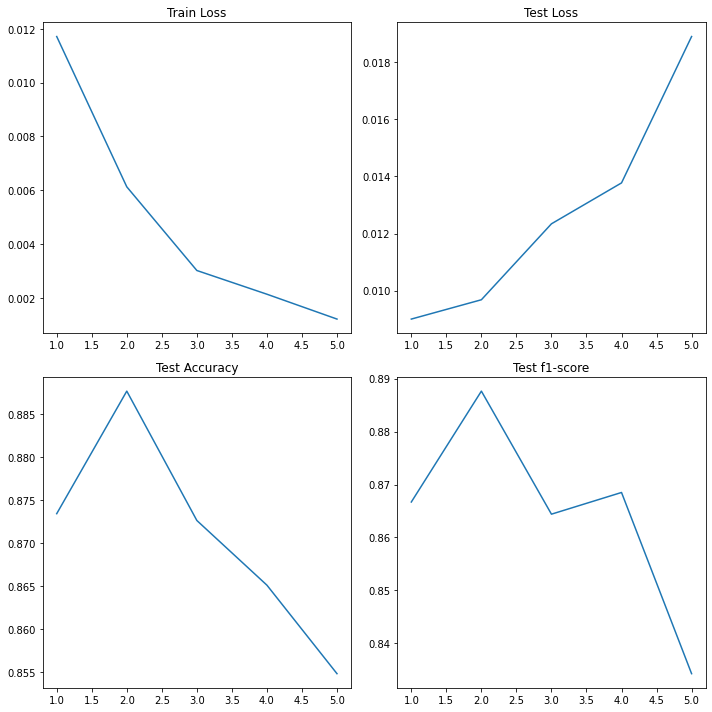

In [30]:
# Plot Measures
get_plots(test_accuracy, test_f1, test_loss, train_loss, epoch_list)

# T5

## Preprocess


In [31]:
# Read the raw data
raw_data = pd.read_csv(data_path+'dataset_raw.csv')
# Shuffle the data
raw_data = raw_data.sample(frac = 1)
# Make copy
data_T5 = raw_data.copy()
# Mapping 0 and 1 to "positive" and "negative"
data_T5['label']=data_T5['label'].map({1: 'positive', 0: 'negative'})

In [32]:
# Adding the "sst2 sentence:" prefix for the reviews
def add_T5_preffix_sentimant_classiication(row):
    row['review'] = "sst2 sentence: " + row['review'] 
    row['label'] = row['label']
    return row

data_T5 = data_T5.apply(lambda row: add_T5_preffix_sentimant_classiication(row), axis =1)


In [33]:
# Make lists for reviews and lables
reviews = data_T5['review'].tolist()
labels  = data_T5['label'].tolist()

In [34]:
# Define T5 Tokenizer and model
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-base")

In [35]:
# T5 base architecture
t5_model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [36]:
# T5 base parameters
n_parameters = sum(p.numel() for p in t5_model.parameters())
print(f"Number of parameters in model: {n_parameters}")

Number of parameters in model: 222903552


In [37]:
# This function uses T5 tokenizer in oreder to tokenize each batch of samples
def tokenizing_batch_T5(X, y, tokenizer) :
    encoding = tokenizer(X, padding="longest", max_length=128, truncation=True, return_tensors="pt")
    input_ids = encoding.input_ids.to(device)
    attention_mask = encoding.attention_mask.to(device)

    target_encoding = tokenizer(y, padding="longest", max_length=2, truncation=True, return_tensors="pt")
    labels = target_encoding.input_ids
    labels = labels.clone().detach()
    labels[labels == tokenizer.pad_token_id] = -100
    labels = labels.to(device)
    
    return input_ids, attention_mask, labels

In [38]:
# Enter model to device
t5_model.to(device)
# Define optimizer
optim = torch.optim.AdamW(t5_model.parameters(), lr = 1e-4)
# Define epochs number
epochs = 5
# Create pytorch data loaders with get_data function
train_dataloader, test_dataloader = get_data(data_T5,
                                            train_size = 10000,
                                            test_size = 2500,
                                            batch_size = 16)

In [39]:
# If training results does not exist, train the model and sace the results dictionary in pickle file
if not os.path.exists(results+"t5_trained_results_dic.pickle"):
    t5_trained_results_dic = fineTuning(model=t5_model,
                                        optim=optim,
                                        epochs= epochs,
                                        train_dataloader = train_dataloader,
                                        test_dataloader=test_dataloader,
                                        tb_dirname ='T5',
                                        tokenizer=t5_tokenizer,
                                        model_type='t5')

    with open('t5_trained_results_dic.pickle', 'wb') as file:
        pickle.dump(t5_trained_results_dic, file, protocol=pickle.HIGHEST_PROTOCOL)
else:
    # Load trained bert results
    with open(results+"t5_trained_results_dic.pickle", "rb") as file:
        t5_trained_results_dic = pickle.load(file)


# T5 Evaluation

In [40]:
# Extract trained t5 results
test_accuracy = t5_trained_results_dic['test_accuracy']
test_f1 = t5_trained_results_dic['test_f1']
test_loss = t5_trained_results_dic['test_loss']
train_loss = t5_trained_results_dic['train_loss']
epoch_list = range(1, epochs+1)

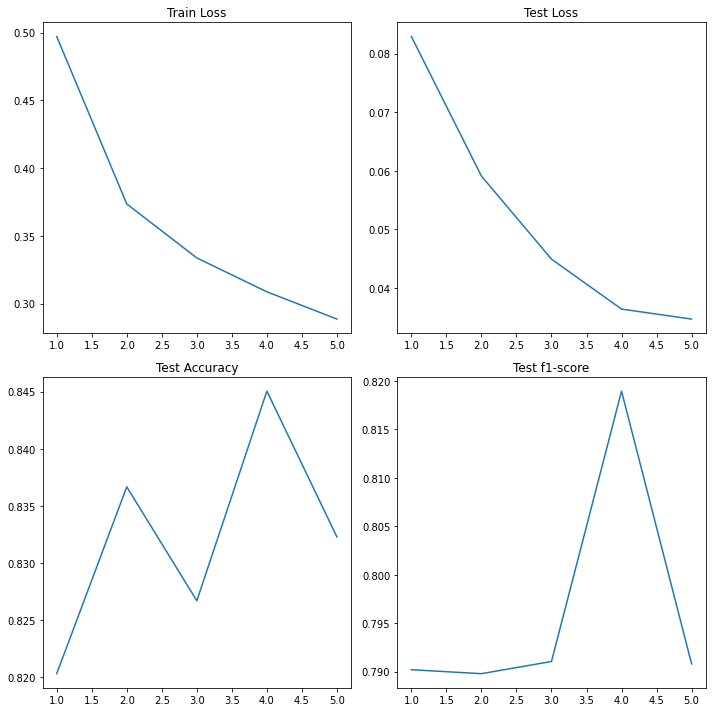

In [41]:
# Plot results
get_plots(test_accuracy, test_f1, test_loss, train_loss, epoch_list)

# Model Compression

## 1. Knowledge distilation with t5-small as a student and t5-base as a teacher

In [42]:
#Define T5 Tokenizer and model
student_tokenizer = T5Tokenizer.from_pretrained("t5-small")
student_model = T5ForConditionalGeneration.from_pretrained("t5-small")

#Define T5 Tokenizer and model
teacher_tokenizer = T5Tokenizer.from_pretrained("t5-base")
teacher_model = T5ForConditionalGeneration.from_pretrained("t5-base")

In [43]:
#Amount of parametes comparison
student_parameters = sum(p.numel() for p in student_model.parameters())
teacher_parameters = sum(p.numel() for p in teacher_model.parameters())
print(f"Number of parameters in student: {student_parameters}")
print(f"Number of parameters in teacher: {teacher_parameters}")
print(f'The ratio between the student and teacher parametes is {round((teacher_parameters/student_parameters), 2)}')

Number of parameters in student: 60506624
Number of parameters in teacher: 222903552
The ratio between the student and teacher parametes is 3.68


In [47]:
#load trained t5-base parameters (after fine tuning on IMDB reviews classification)
try:
    checkpoint = torch.load(models_trained_params+'t5_trained_params.pt')
except:
    checkpoint = torch.load(models_trained_params+'t5_trained_params.pt', map_location=torch.device('cpu'))

teacher_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [48]:
#Train and evaluation loop
def knowlege_distilation_training(teacher_model, student_model, teacher_tokenizer, student_tokenizer, loss_function, alpha, optim, epochs, train_dataloader, test_dataloader, tb_dirname, model_type):
    train_loss_list = []
    test_loss_list = []
    test_accuracy_list = []
    test_f1_list = []
    writer = SummaryWriter(log_dir=f'{tb_dir}/{tb_dirname}_{time.time()}')

    for epoch in range(epochs):
        running_loss = 0
        student_model.train()
        train_loop = tqdm(train_dataloader)
        for X, y in train_loop:
            optim.zero_grad()
            # Tokenize input for the teacher model (T5-base)
            teacher_ids, teacher_mask, teacher_labels = tokenizing_batch_T5(X, y, teacher_tokenizer)
            # predicition
            teacher_outputs = teacher_model(input_ids=teacher_ids,
                                    attention_mask=teacher_mask,
                                    labels=teacher_labels)
            #Extract the logits vector
            teacher_logits = teacher_outputs.logits
            
            # Tokenize input for the student model (T5-small)
            student_ids, student_mask, student_labels = tokenizing_batch_T5(X, y, student_tokenizer)
            # prediction
            student_outputs = student_model(input_ids=student_ids,
                                    attention_mask=student_mask,
                                    labels=student_labels)
            # Extract to logits vector
            student_logits = student_outputs.logits
            # Calculate the MSE loss betweem the teacher and the student logits
            loss_teacher = loss_function(student_logits, teacher_logits)
            # Cacluate the loss of the student model compare to the ground truth label
            loss_ground_truth = student_outputs.loss
            # Calculate the final loss as weighted average of the two losses
            loss = alpha * loss_teacher + (1-alpha) * loss_ground_truth
            loss.backward()
            optim.step()
            running_loss+=loss.item()
            train_loop.set_description(f'Epoch {epoch}')
            train_loop.set_postfix(loss=loss.item())
        
        epoch_train_loss = running_loss/len(train_dataloader.dataset)
        train_loss_list.append(epoch_train_loss)

        test_loss = 0
        test_accuracy = 0
        test_f1 = 0
        teacher_model.eval()
        with torch.no_grad():
            eval_loop = tqdm(test_dataloader)
            for X_test, y_test in eval_loop:
                ids, mask, labels = tokenizing_batch_T5(X_test, y_test, student_tokenizer)
                generated_ids = student_model.generate( input_ids=ids,
                                                attention_mask=mask,
                                                max_length=2)
                loss = student_model(input_ids=ids, labels=labels).loss
                y_pred = [student_tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
                labels = [student_tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in labels]  
                batch_accuracy = calc_metric(labels, y_pred, model_type, 'accuracy')
                batch_f1 = calc_metric(labels, y_pred, model_type, 'f1_score')  

                batch_test_loss = loss.item()
                test_loss+=batch_test_loss
                test_accuracy+=batch_accuracy
                test_f1+=batch_f1
                eval_loop.set_description(f'Epoch {epoch}')
                eval_loop.set_postfix(loss=batch_test_loss)
                
        epoch_accuracy = test_accuracy/len(test_dataloader)
        test_accuracy_list.append(epoch_accuracy)
        epoch_f1 = test_f1/len(test_dataloader)
        test_f1_list.append(epoch_f1)
        epoch_test_loss = test_loss/len(test_dataloader.dataset)
        test_loss_list.append(epoch_test_loss)

        writer.add_scalar(tag='loss/train', scalar_value=epoch_train_loss, global_step=epoch)
        writer.add_scalar(tag='loss/test', scalar_value=epoch_test_loss, global_step=epoch)
        writer.add_scalar(tag='accuracy/test', scalar_value=epoch_accuracy, global_step=epoch)
    
    trained_model_params_path = 'student_model_trained_params.pt'
    torch.save({
            'model_state_dict': student_model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            }, trained_model_params_path)
       
    return {
            'train_loss':train_loss_list,
            'test_loss':test_loss_list,
            'test_accuracy':test_accuracy_list,
            'test_f1':test_f1_list,
            }

In [49]:
#Enter model to device
student_model.to(device)
teacher_model.to(device)
#Define optimizer
optim = torch.optim.AdamW(student_model.parameters(), lr = 5e-5)
#Define epochs number
epochs = 5
#Apply get data function
train_dataloader, test_dataloader = get_data(data_T5,
                                            train_size = 10000,
                                            test_size = 2500,
                                            batch_size = 8)

In [50]:
if not os.path.exists(results+"t5_small_trained_results_dic.pickle"):
    t5_small_trained_results_dic = knowlege_distilation_training( teacher_model=teacher_model,
                                                            student_model=student_model,
                                                            teacher_tokenizer= teacher_tokenizer,
                                                            student_tokenizer= student_tokenizer,
                                                            loss_function=torch.nn.MSELoss(),
                                                            alpha = 0.5,
                                                            optim = optim,
                                                            epochs= epochs,
                                                            train_dataloader = train_dataloader,
                                                            test_dataloader=test_dataloader,
                                                            tb_dirname ='knowledgeDistilation',
                                                            model_type='t5')

    #Save model parameters
    with open('t5_small_trained_results_dic.pickle', 'wb') as file:
        pickle.dump(t5_small_trained_results_dic, file, protocol=pickle.HIGHEST_PROTOCOL)

else:
    # Load trained bert results
    with open(results+"t5_small_trained_results_dic.pickle", "rb") as file:
        t5_small_trained_results_dic = pickle.load(file)

# T5 small - knowledge distilation evaluation

In [51]:
# Extract trained t5 small results
test_accuracy = t5_small_trained_results_dic['test_f1']
test_f1 = t5_small_trained_results_dic['test_accuracy']
test_loss = t5_small_trained_results_dic['test_loss']
train_loss = t5_small_trained_results_dic['train_loss']
epoch_list = range(1, epochs+1)

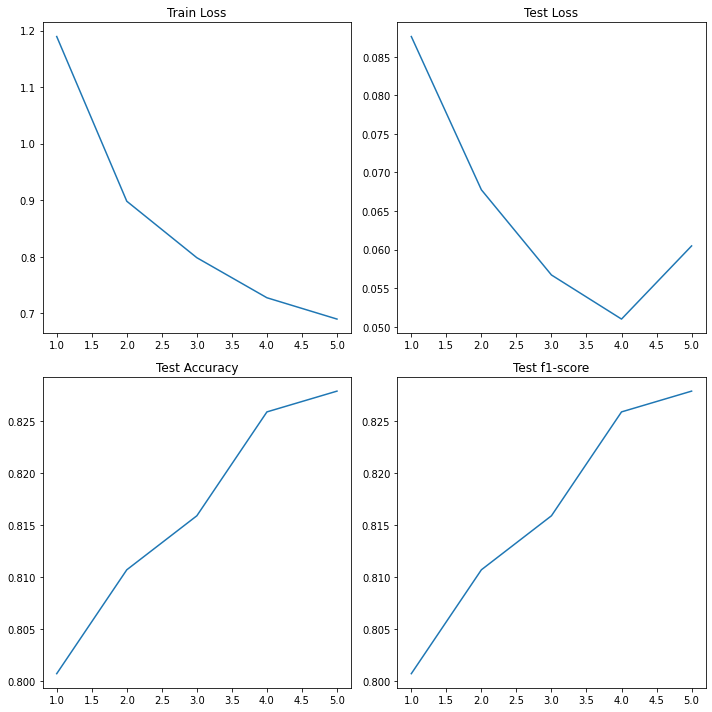

In [52]:
get_plots(test_accuracy, test_f1, test_loss, train_loss, epoch_list)

## 2. Pruning Bert Weights - global unstructured one-shot pruning

In [53]:
# Define Bert tokenizer and model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
try:
    checkpoint = torch.load(models_trained_params+'bert_trained_params.pt')
except:
    checkpoint = torch.load(models_trained_params+'bert_trained_params.pt', map_location=torch.device('cpu'))
bert_model.load_state_dict(checkpoint['model_state_dict'])
#Enter model to device
bert_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [54]:
# global, unstructured, one shot pruning
def prune_model_global_unstructured(model, layer_type, proportion):
    module_tups = []
    for module in model.modules():
        if isinstance(module, layer_type):
            module_tups.append((module, 'weight'))

    prune.global_unstructured(
        parameters=module_tups, pruning_method=prune.L1Unstructured,
        amount=proportion
    )
    for module, _ in module_tups:
        prune.remove(module, 'weight')
    return model

In [55]:
# This is the evaluation part in the training flow
# That function itterats over each batch and the different measures on test set
def model_evaluation(model, tokenizer, test_dataloader, model_type):
    test_loss = 0
    test_accuracy = 0
    test_f1 = 0
    model.eval()
    with torch.no_grad():
        eval_loop = tqdm(test_dataloader)
        for X_test, y_test in eval_loop:
            input_ids, token_type_ids, attention_mask, labels = tokenizing_batch_Bert(X_test, y_test, tokenizer)
            outputs = model(input_ids, attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels)
            y_pred = logits_to_prediction_list(outputs.logits)
            loss = outputs.loss
            batch_accuracy = calc_metric(labels, y_pred, model_type, 'accuracy')
            batch_f1 = calc_metric(labels, y_pred, model_type, 'f1_score')
            batch_test_loss = loss.item()
            test_loss+=batch_test_loss
            test_accuracy+=batch_accuracy
            test_f1+=batch_f1  
    epoch_accuracy = test_accuracy/len(test_dataloader)
    epoch_f1 =  test_f1/len(test_dataloader)
    epoch_test_loss = test_loss/len(test_dataloader.dataset)

    return  {   'test_accuracy': epoch_accuracy,
                'test_f1': epoch_f1,
                'test_loss': epoch_test_loss
            }

In [56]:
train_dataloader, test_dataloader = get_data(raw_data,
                                            train_size = 10000,
                                            test_size = 2500,
                                            batch_size = 16)

In [57]:
# This function evaluate the performence of bert with different pruning ratios
def testing_different_proportion_pruning(original_model, tokenizer, dataloader ,model_type, min_proportion, max_proportion, jump):
    proportion_values = np.arange(min_proportion, max_proportion+jump, jump)
    accuracy_results = []
    f1_results = []
    average_loss_results = []
    for proportion in proportion_values:
        pruned_model = prune_model_global_unstructured(original_model, nn.modules.linear.Linear, proportion)
        test_results = model_evaluation(pruned_model, tokenizer, dataloader, model_type)
        accuracy_results.append(test_results['test_accuracy'])
        f1_results.append(test_results['test_f1'])
        average_loss_results.append(test_results['test_loss'])
        torch.cuda.empty_cache() 
    return  {   'accuracy_per_pruning_proportion': accuracy_results,
                'f1_score_per_pruning_proportion': f1_results,
                'average_loss_per_pruning_proportion': average_loss_results
            }

In [58]:
if not os.path.exists(results+"pruned_bert_results_dic.pickle"):
    #evaluation with different pruning ratio
    pruned_bert_evaluation_results = testing_different_proportion_pruning(bert_model, bert_tokenizer, test_dataloader, 'bert', 0.1, 0.9, 0.1)
    #Save model parameters
    with open('pruned_bert_results_dic.pickle', 'wb') as file:
        pickle.dump(pruned_bert_evaluation_results, file, protocol=pickle.HIGHEST_PROTOCOL)
else:
    # Load trained bert results
    with open(results+"pruned_bert_results_dic.pickle", "rb") as file:
        pruned_bert_evaluation_results = pickle.load(file)
    

In [59]:
# Process results in order to plot them
proportion_pruning_values =['10%' ,'20%' ,'30%', '40%', '50%', '60%', '70%', '80%', '90%'] 
bert_pruned_accuracy_dic ={'accuracy': pruned_bert_evaluation_results['accuracy_per_pruning_proportion'], 'proportion_of_pruning': proportion_pruning_values}
bert_pruned_f1_score_dic = {'f1_score':pruned_bert_evaluation_results['f1_score_per_pruning_proportion'], 'proportion_of_pruning': proportion_pruning_values}
bert_pruned_mean_loss = {'loss':pruned_bert_evaluation_results['average_loss_per_pruning_proportion'], 'proportion_of_pruning': proportion_pruning_values}

accuracy_df = pd.DataFrame(bert_pruned_accuracy_dic)
f1_score_df = pd.DataFrame(bert_pruned_f1_score_dic)
loss_df = pd.DataFrame(bert_pruned_mean_loss)


In [60]:
# Plot results
fig = px.bar(accuracy_df, x='proportion_of_pruning', y='accuracy', orientation='v', title='Accuracy vs Proportion of Pruning')
fig.show()
fig = px.bar(f1_score_df, x='proportion_of_pruning', y='f1_score', orientation='v', title='F1-Score vs Proportion of Pruning', range_color='green')
fig.show()
fig = px.line(loss_df, x='proportion_of_pruning', y='loss', orientation='v', title='loss vs Proportion of Pruning')
fig.show()